In [169]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from sklearn.metrics import accuracy_score


# training_data = datasets.EMNIST(
#     root="Downloads/cnn/cnn_dataset",
#     train=True,
#     download=True,
#     transform=ToTensor(),
#     split="mnist"
# )

# test_data = datasets.EMNIST(
#     root="Downloads/cnn/cnn_dataset",
#     train=False,
#     download=True,
#     transform=ToTensor(),
#     split="mnist"
# )

In [170]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.ToTensor(),   
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root="cnn/cnn_dataset", transform=transform)

In [171]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

training_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [172]:
print(train_size)

70561


In [173]:
print(test_size)

15121


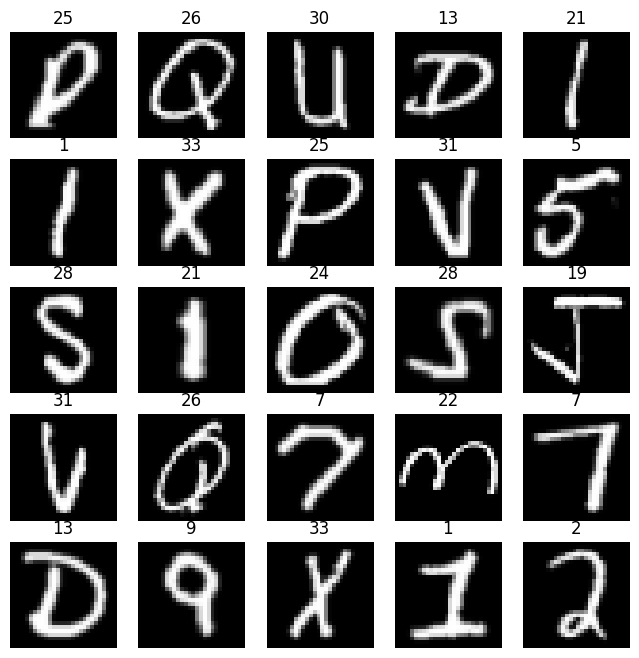

In [174]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [175]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

num_classes = 36
learning_rate = 0.001
num_epochs = 20

In [176]:
# Create DataLoaders
batch_size = 32
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [177]:
import torch
import torch.nn as nn

class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.convlayer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)  # Changed `in_channels` to 1
        self.convlayer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)

        self.convlayer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.convlayer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(1024, 128)
        self.relu1 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.convlayer1(x)
        out = self.convlayer2(out)
        out = self.max_pool1(out)
        out = self.dropout1(out)

        out = self.convlayer3(out)
        out = self.convlayer4(out)
        out = self.max_pool2(out)
        out = self.dropout2(out)

        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout3(out)
        out = self.fc2(out)
        return out

In [178]:
model = ConvNeuralNet(num_classes)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [179]:
import torch

def train(model, train_loader, val_loader, epochs):
    train_loss = []
    val_loss_list = []
    val_acc_list = []
    train_acc_list = []
    best_val_acc = 0.0
    best_model_path = 'best_model.pth'  # Path to save the best model

    start_time = time.time()

    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0.0
        correct_pred = 0
        total_pred = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_pred += (predicted == labels).sum().item()
            total_pred += labels.size(0)

        avg_train_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        train_acc = correct_pred / total_pred
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        correct_val_pred = 0
        total_val_pred = 0
        val_epoch_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_outputs = model(inputs)
                val_loss = loss_function(val_outputs, labels)
                val_epoch_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                correct_val_pred += (val_predicted == labels).sum().item()
                total_val_pred += labels.size(0)

            avg_val_loss = val_epoch_loss / len(val_loader)
            val_loss_list.append(avg_val_loss)
            val_acc = correct_val_pred / total_val_pred
            val_acc_list.append(val_acc)

            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), best_model_path)  # best model
                print(f"New best model saved at epoch {epoch+1} with validation accuracy {val_acc:.4f}")

        # Print results
        print(f'Epoch {epoch + 1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Validation Accuracy: {val_acc:.4f}')

    print(f'Training Complete. Time taken: {time.time() - start_time:.2f} seconds.')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')

    return train_loss, val_loss_list, val_acc_list, train_acc_list

# Train the model
train_loss, val_loss_list, val_acc_list, train_acc_list = train(model, train_loader, val_loader, epochs=20)

New best model saved at epoch 1 with validation accuracy 0.7286
Epoch 1/20, Train Loss: 2.2802, Validation Loss: 0.8609, Validation Accuracy: 0.7286
New best model saved at epoch 2 with validation accuracy 0.8105
Epoch 2/20, Train Loss: 0.9988, Validation Loss: 0.5825, Validation Accuracy: 0.8105
New best model saved at epoch 3 with validation accuracy 0.8332
Epoch 3/20, Train Loss: 0.8012, Validation Loss: 0.4969, Validation Accuracy: 0.8332
New best model saved at epoch 4 with validation accuracy 0.8454
Epoch 4/20, Train Loss: 0.7136, Validation Loss: 0.4492, Validation Accuracy: 0.8454
New best model saved at epoch 5 with validation accuracy 0.8487
Epoch 5/20, Train Loss: 0.6603, Validation Loss: 0.4305, Validation Accuracy: 0.8487
New best model saved at epoch 6 with validation accuracy 0.8589
Epoch 6/20, Train Loss: 0.6250, Validation Loss: 0.4028, Validation Accuracy: 0.8589
Epoch 7/20, Train Loss: 0.5957, Validation Loss: 0.3942, Validation Accuracy: 0.8579
New best model saved 

In [180]:
# Load the best model for testing
model.load_state_dict(torch.load('best_model.pth'))

/var/folders/qy/wgzvwpzd64x2s2rf70p6wm8r0000gn/T/ipykernel_50736/4096917100.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.

<All keys matched successfully>

In [181]:
def test(model, test_loader):
    model.eval()  
    test_loss = 0.0
    correct_test_pred = 0
    total_test_pred = 0

    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to the correct device
            test_outputs = model(inputs)
            loss = loss_function(test_outputs, labels)
            test_loss += loss.item()  # Accumulate test loss

            # Get predictions
            _, test_predicted = torch.max(test_outputs, 1)
            correct_test_pred += (test_predicted == labels).sum().item() 
            total_test_pred += labels.size(0)  

    avg_test_loss = test_loss / len(test_loader)  
    test_acc = correct_test_pred / total_test_pred  # accuracy

    print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_acc:.4f}')
    return avg_test_loss, test_acc

# Call the test function
avg_test_loss, test_acc = test(model, test_loader)

Test Loss: 0.3248, Test Accuracy: 0.8827
